## Features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

In [2]:
# !unzip -p *.zip
# !gzip -d *.gz

In [3]:
!ls

Fragmentation, Price Formation, and Cross-Impact in Bitcoin Markets.pdf
__MACOSX
__pycache__
book.csv
book.spot.csv
hw1.ipynb
metric_clf_hft.py
target.csv
ticker.csv
ticker.spot.csv
trades.csv
trades.spot.csv


In [4]:
target = pd.read_csv("target.csv")
ticker = pd.read_csv("ticker.csv")
ticker_spot = pd.read_csv("ticker.spot.csv")
trades = pd.read_csv("trades.csv")
trades_spot = pd.read_csv("trades.spot.csv")
book = pd.read_csv("book.csv")
book_spot = pd.read_csv("book.spot.csv")

In [5]:
trades.shape, ticker.shape, book.shape, trades_spot.shape, ticker_spot.shape, book_spot.shape

((20548912, 7),
 (37566023, 8),
 (6403491, 104),
 (7257144, 7),
 (17783533, 6),
 (2305858, 104))

In [6]:
target.target.value_counts()

 0    18049007
 1     9806614
-1     9709959
Name: target, dtype: int64

In [7]:
target[target.local_ts.duplicated()]

,local_ts,target
3966,1679443224708626991,1
7727,1679443236434154496,0
10319,1679443250342057984,-1
13468,1679443264894314681,0
19314,1679443286528796160,1
...,...,...
37507738,1679701483764037888,0
37520113,1679701662131192832,0
37521969,1679701692057069824,-1
37533541,1679701885130233088,-1


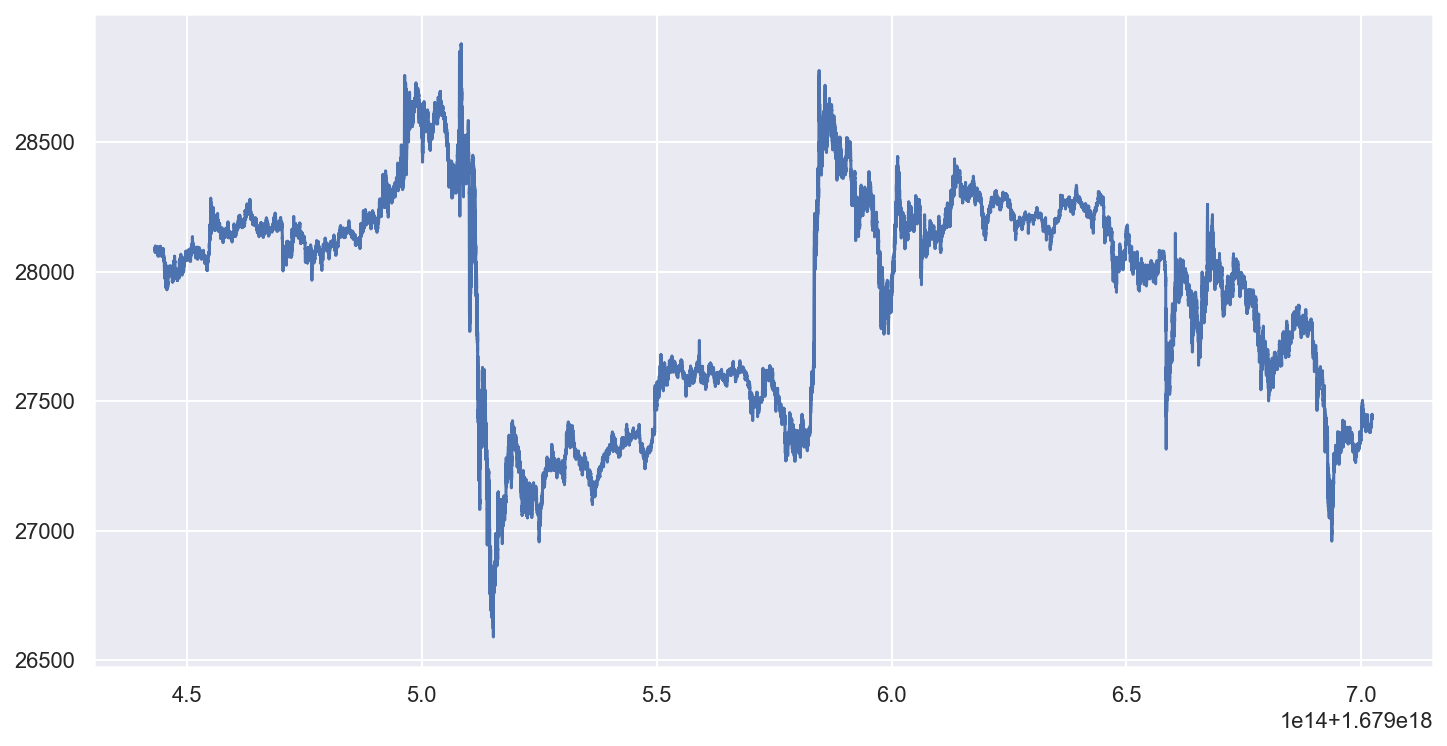

In [8]:
plt.plot(book.timestamp, book["asks[0].price"])

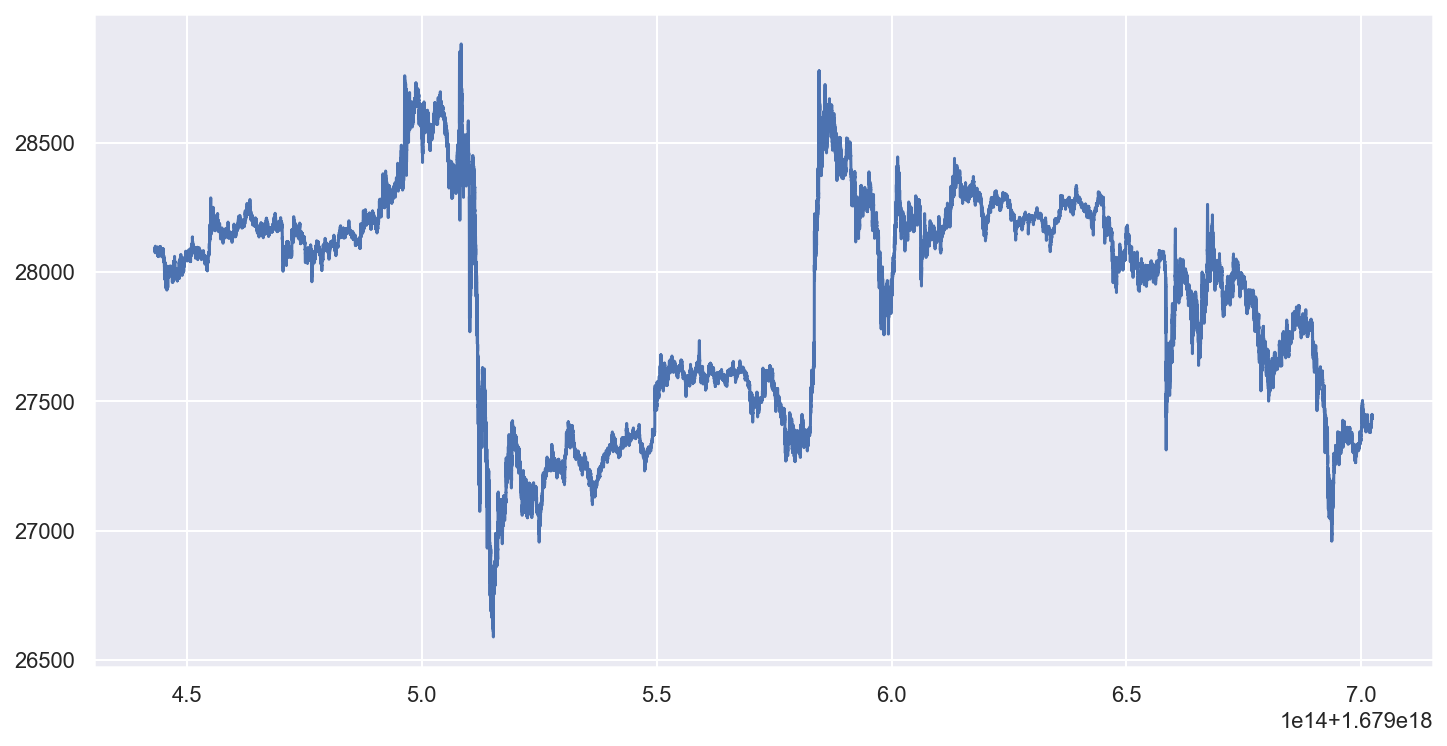

In [9]:
plt.plot(trades.local_ts, trades["price"])

In [10]:
ticker[ticker.local_ts == target.local_ts[0]]

,local_ts,seq,remote_ts,remote_ts2,bid_price,bid_amount,ask_price,ask_amount
0,1679443200002269696,2664656597671,1679443199998,1679443199993,28091.1,0.885,28091.2,17.243


In [11]:
df = target.copy()
# skip first n cause target starts before some of other data
skip_n = 30
# dropping 30 records from 37565580 is kinda fine...
target_start = df[skip_n:].local_ts.min()
assert book.timestamp.min() < target_start
assert book_spot.timestamp.min() < target_start
assert trades.local_ts.min() < target_start
assert trades_spot.local_ts.min() < target_start
assert ticker.local_ts.min() < target_start
assert ticker_spot.local_ts.min() < target_start
df = df[skip_n:].reset_index(drop = True)
df = df.drop_duplicates(subset = ["local_ts"], keep = "last")
target.shape[0], df.shape[0]

(37565580, 37556651)

df["book_imabalance"] = None

df["trade_imabalance"] = None

df["past_returns"] = None

df["mean_divergence"] = None

df["el_nonlinearities"] = None

In [23]:
# before added fast merge
ts = df.local_ts[0]
df_slice = book[book.local_timestamp < ts]
amax = df_slice.local_timestamp.argmax()
row = df_slice.iloc[amax]

bids_amount = row["bids[0].amount"]
asks_amount = row["asks[0].amount"]

(bids_amount - asks_amount) / (bids_amount + asks_amount)

-0.9994191955858865

(bid[0].volume - ask[0].volume)/(bid[0].volume + ask[0].volume)

In [24]:
def add_data(df, data, cols_to_keep, timestamp = "remote_ts", prefix = "_"):
    data = data[cols_to_keep].copy().sort_values(by = [timestamp])
    rename_mapper = {row: prefix + row for row in cols_to_keep}
    rename_mapper[timestamp] = "local_ts"
    data = data.rename(columns = rename_mapper)
    return pd.merge_asof(df, data, on = "local_ts", direction = "backward")
# probably better to use machine timestamp then local_timestamp
# maybe problems with how we wont get it in time, but prob fine
timestamp_to_use = "timestamp" # "local_timestamp" 

In [25]:
df_book = add_data(df, book, [timestamp_to_use, "asks[0].amount", "bids[0].amount"]\
         , timestamp = timestamp_to_use, prefix = "book_")
asks_amount = df_book["book_asks[0].amount"].to_numpy()
bids_amount = df_book["book_bids[0].amount"].to_numpy()
df["book_future_imabalance"] = (bids_amount - asks_amount) / (bids_amount + asks_amount)
df["book_future_log_imbalance_custom"] = np.log(bids_amount/asks_amount)

In [26]:
df_book = add_data(df, book_spot, [timestamp_to_use, "asks[0].amount", "bids[0].amount"]\
         , timestamp = timestamp_to_use, prefix = "book_")
asks_amount = df_book["book_asks[0].amount"].to_numpy()
bids_amount = df_book["book_bids[0].amount"].to_numpy()
df["book_spot_imabalance"] = (bids_amount - asks_amount) / (bids_amount + asks_amount)
df["book_spot_log_imbalance_custom"] = np.log(bids_amount/asks_amount)

In [27]:
df.tail()

,local_ts,target,book_future_imabalance,book_future_log_imbalance_custom,book_spot_imabalance,book_spot_log_imbalance_custom
37565545,1679702389831526400,0,0.026748,0.053508,0.675641,1.6421
37565546,1679702389831611648,0,0.026748,0.053508,0.675641,1.6421
37565547,1679702389904044288,0,0.044043,0.088142,0.675641,1.6421
37565548,1679702389957030912,0,0.040025,0.080092,0.675641,1.6421
37565549,1679702389960942592,0,0.040025,0.080092,0.675641,1.6421


In [28]:
trades.head()

,local_ts,seq,remote_ts,remote_ts2,price,amount,side
0,1679443200000453376,3467110982,1679443199997,1679443199993,28091.1,0.001,S
1,1679443200001720832,3467110983,1679443199997,1679443199993,28091.1,0.003,S
2,1679443200022432256,3467110984,1679443200001,1679443199996,28091.1,0.007,S
3,1679443200022432406,3467110985,1679443200001,1679443199996,28091.1,0.001,S
4,1679443200022597888,3467110986,1679443200001,1679443199996,28091.1,0.004,S


In [29]:
def trades_period(df, trades, lookback_window = 2000):
    lookback_window *= 1e6 # from milisec
    trades_remote_ts = trades.remote_ts * 1e6 # from milisec
    
    l = np.searchsorted(trades_remote_ts + lookback_window, df.local_ts)
    l = np.maximum(l - 1, 0)
    r = np.searchsorted(trades_remote_ts, df.local_ts)
    cumsum = np.cumsum(trades.amount).to_numpy()
    
    return cumsum[r] - cumsum[l]

In [30]:
trades_types = {"trades_future": trades, "trades_spot": trades_spot}
for tt_type in trades_types:
    for window_ms in tqdm([100, 250, 500, 1000, 2000], desc = tt_type):
        tt = trades_types[tt_type]
        trades_buy = trades_period(df, tt[tt.side == "B"], lookback_window = window_ms)
        trades_sell = trades_period(df, tt[tt.side == "S"], lookback_window = window_ms)
        df[f"{tt_type}_imb_{window_ms}ms"] = trades_buy - trades_sell

In [31]:
df.head()

,local_ts,target,book_future_imabalance,book_future_log_imbalance_custom,book_spot_imabalance,book_spot_log_imbalance_custom,trades_future_imb_100ms,trades_future_imb_250ms,trades_future_imb_500ms,trades_future_imb_1000ms,trades_future_imb_2000ms,trades_spot_imb_100ms,trades_spot_imb_250ms,trades_spot_imb_500ms,trades_spot_imb_1000ms,trades_spot_imb_2000ms
0,1679443205344112384,-1,-0.999419,-8.143953,0.84,2.442347,0.117,0.117,0.117,0.117,0.117,-0.15459,-0.17668,-0.16682,-1.14067,-1.31537
1,1679443205349040896,-1,-0.999419,-8.143953,0.84,2.442347,0.865,0.865,0.865,0.865,0.865,-0.15459,-0.17668,-0.16682,-1.14067,-1.40737
2,1679443205350975232,-1,-0.999419,-8.143953,0.84,2.442347,0.865,0.865,0.865,0.865,0.865,-0.15459,-0.17668,-0.16682,-1.14067,-1.40737
3,1679443205352709632,-1,-0.999344,-8.021585,0.84,2.442347,1.952,1.952,1.952,1.952,1.952,-0.15497,-0.17668,-0.16682,-1.13662,-1.40737
4,1679443205356733140,-1,-0.999344,-8.021585,0.84,2.442347,1.952,1.952,1.952,1.952,1.952,-0.15497,-0.17668,-0.16682,-1.13662,-1.40737


Text(0.5, 1.0, 'Power of leverage 1000ms')

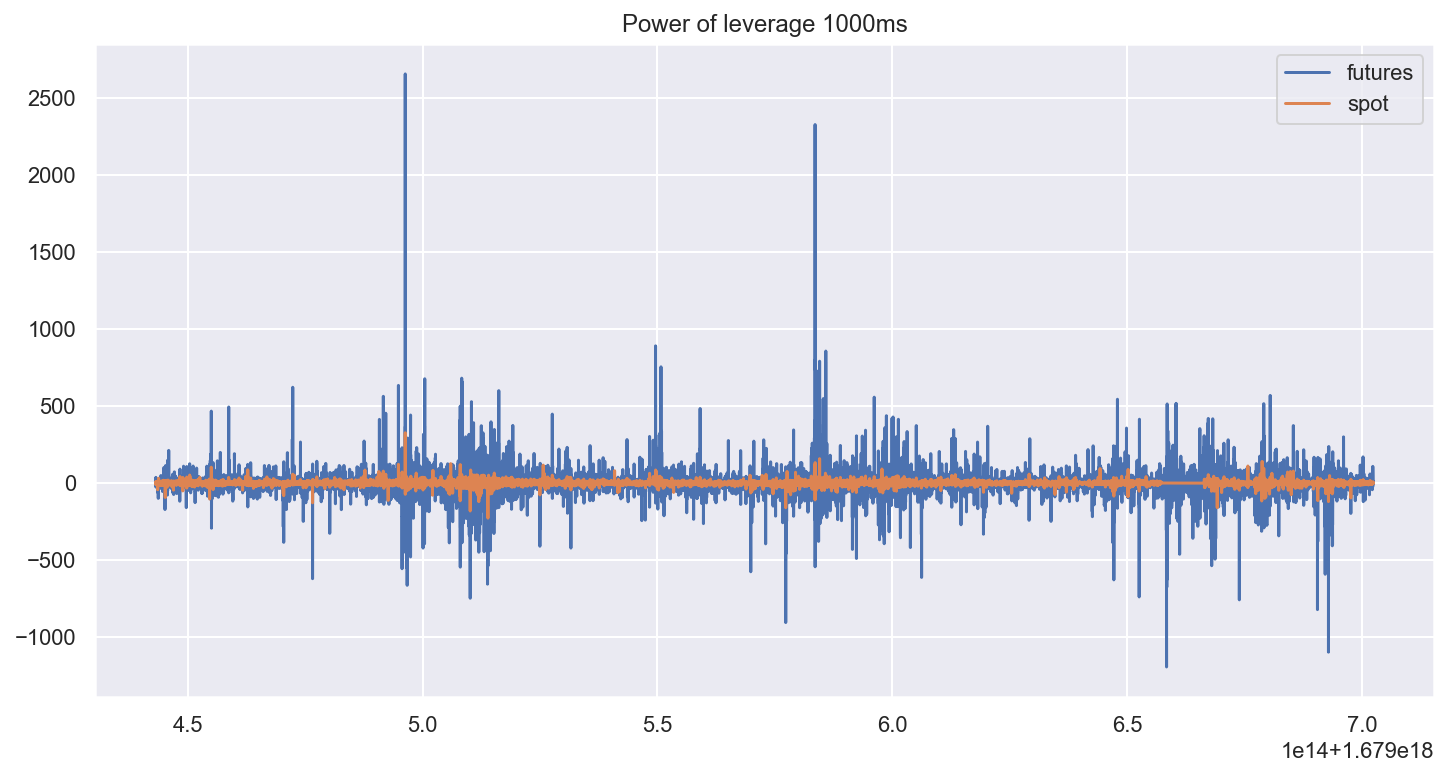

In [32]:
plt.plot(df.local_ts, df.trades_future_imb_1000ms, label = "futures")
plt.plot(df.local_ts, df.trades_spot_imb_1000ms, label = "spot")
plt.legend(loc = 'upper right')
plt.title("Power of leverage 1000ms")

In [33]:
def trades_price_avg_lookback(df, trades, time_horizon = 5000, lookback_window = 50):
    time_horizon *= 1e6 # from milisec
    lookback_window *= 1e6 # from milisec
    trades_remote_ts = trades.remote_ts * 1e6 + time_horizon # from milisec

    l = np.searchsorted(trades_remote_ts + lookback_window, df.local_ts)
    l = np.maximum(l - 1, 0)
    r = np.searchsorted(trades_remote_ts, df.local_ts)
    cumsum = np.cumsum(trades.price).to_numpy()
    nums = np.arange(trades.shape[0])

    price_sum = cumsum[r] - cumsum[l]
    price_num = nums[r] - nums[l]
    return price_sum / price_num

In [34]:
# ticker_types = {"ticker_future": ticker, "ticker_spot": ticker_spot} 
# used trades as in paper
for tt_type in trades_types:
    for window_ms in tqdm([100, 250, 500, 1000, 2000], desc = tt_type):
        tt = trades_types[tt_type]
        price_now = trades_price_avg_lookback(df, tt, time_horizon = 0)
        price_past = trades_price_avg_lookback(df, tt, time_horizon = window_ms)
        df[f"{tt_type}_past_returns_{window_ms}ms"] = (price_now / price_past - 1) * 1000 

In [35]:
df.head()

,local_ts,target,book_future_imabalance,book_future_log_imbalance_custom,book_spot_imabalance,book_spot_log_imbalance_custom,trades_future_imb_100ms,trades_future_imb_250ms,trades_future_imb_500ms,trades_future_imb_1000ms,trades_future_imb_2000ms,trades_spot_imb_100ms,trades_spot_imb_250ms,trades_spot_imb_500ms,trades_spot_imb_1000ms,trades_spot_imb_2000ms,trades_future_past_returns_100ms,trades_future_past_returns_250ms,trades_future_past_returns_500ms,trades_future_past_returns_1000ms,trades_future_past_returns_2000ms,trades_spot_past_returns_100ms,trades_spot_past_returns_250ms,trades_spot_past_returns_500ms,trades_spot_past_returns_1000ms,trades_spot_past_returns_2000ms
0,1679443205344112384,-1,-0.999419,-8.143953,0.84,2.442347,0.117,0.117,0.117,0.117,0.117,-0.15459,-0.17668,-0.16682,-1.14067,-1.31537,0.0,0.0,0.0,0.0,0.0,-0.021526,-0.066921,0.003301,-0.081830,-0.079251
1,1679443205349040896,-1,-0.999419,-8.143953,0.84,2.442347,0.865,0.865,0.865,0.865,0.865,-0.15459,-0.17668,-0.16682,-1.14067,-1.40737,0.0,0.0,0.0,0.0,0.0,0.007828,-0.037569,0.032656,-0.052478,-0.070570
2,1679443205350975232,-1,-0.999419,-8.143953,0.84,2.442347,0.865,0.865,0.865,0.865,0.865,-0.15459,-0.17668,-0.16682,-1.14067,-1.40737,0.0,0.0,0.0,0.0,0.0,0.007828,-0.037569,0.032656,-0.052478,-0.070570
3,1679443205352709632,-1,-0.999344,-8.021585,0.84,2.442347,1.952,1.952,1.952,1.952,1.952,-0.15497,-0.17668,-0.16682,-1.13662,-1.40737,0.0,0.0,0.0,0.0,0.0,0.010674,-0.037569,0.032656,-0.034195,-0.070570
4,1679443205356733140,-1,-0.999344,-8.021585,0.84,2.442347,1.952,1.952,1.952,1.952,1.952,-0.15497,-0.17668,-0.16682,-1.13662,-1.40737,0.0,0.0,0.0,0.0,0.0,0.010674,-0.037569,0.032656,-0.034195,-0.070570


In [36]:
def price_sets(trades, time_sets, lookback_window = 50 * 1e6):
    trades_remote_ts = trades.remote_ts * 1e6 # from milisec

    l = np.searchsorted(trades_remote_ts + lookback_window, time_sets)
    l = np.maximum(l - 1, 0)
    r = np.searchsorted(trades_remote_ts, time_sets)
    cumsum = np.cumsum(trades.price).to_numpy()
    nums = np.arange(trades.shape[0])

    price_sum = cumsum[r] - cumsum[l]
    price_num = nums[r] - nums[l]
    return price_sum / price_num

def rolling_mean(df, time_sets, rolling_price, time_horizon = 5000):
    time_horizon *= 1e6 # from milisec

    l = np.searchsorted(time_sets + time_horizon, df.local_ts)
    l = np.maximum(l - 1, 0)
    r = np.searchsorted(time_sets, df.local_ts)
    cumsum = np.cumsum(rolling_price)
    nums = np.arange(rolling_price.shape[0])

    price_sum = cumsum[r] - cumsum[l]
    price_num = nums[r] - nums[l]
    return price_sum / price_num

In [37]:
def d (price_1, price_2):
    return (price_1 / price_2 - 1) * 10000
def DIV(df, trades_market_1, trades_market_2, time_horizon = 5000, lookback_window = 50):
    price_now_1 = trades_price_avg_lookback(df, trades_market_1\
                                            , time_horizon = 0, lookback_window = lookback_window)
    price_now_2 = trades_price_avg_lookback(df, trades_market_2\
                                            , time_horizon = 0, lookback_window = lookback_window)
    
    d_now = d(price_now_1, price_now_2)
    
    # price_rolling_1 = trades_price_avg_lookback(df, trades_market_1\
    #                                        , time_horizon = 0, lookback_window = time_horizon)
    # price_rolling_2 = trades_price_avg_lookback(df, trades_market_2\
    #                                        , time_horizon = 0, lookback_window = time_horizon)
    
    # print("prices_now_done")
    
    trades_market_1 = trades
    trades_market_2 = trades_spot
    start = min(trades_market_1.remote_ts.min(), trades_market_2.remote_ts.min()) * 1e6
    end   = max(trades_market_1.remote_ts.max(), trades_market_2.remote_ts.max()) * 1e6
    lookback_window *= 1e6
    time_sets = start + (np.arange(np.floor((end - start) / lookback_window)) + 1) * lookback_window
    
    trades_sets_1 = price_sets(trades_market_1, time_sets, lookback_window = lookback_window)
    trades_sets_2 = price_sets(trades_market_2, time_sets, lookback_window = lookback_window)
    
    # print("trades_sets_done")
    
    rolling_price = d(trades_sets_1, trades_sets_2)
    d_rolling = rolling_mean(df, time_sets, rolling_price, time_horizon = time_horizon)
    
    return d_now - d_rolling

In [38]:
for window_s in tqdm([5, 10, 20, 40]):
    window_ms = window_s * 1e3
    df[f"trades_div_{round(window_ms)}ms"] = DIV(df, trades, trades_spot, time_horizon = window_ms)

prices_now_done
trades_sets_done
prices_now_done
trades_sets_done
prices_now_done
trades_sets_done
prices_now_done
trades_sets_done



In [39]:
df.head()

,local_ts,target,book_future_imabalance,book_future_log_imbalance_custom,book_spot_imabalance,book_spot_log_imbalance_custom,trades_future_imb_100ms,trades_future_imb_250ms,trades_future_imb_500ms,trades_future_imb_1000ms,trades_future_imb_2000ms,trades_spot_imb_100ms,trades_spot_imb_250ms,trades_spot_imb_500ms,trades_spot_imb_1000ms,trades_spot_imb_2000ms,trades_future_past_returns_100ms,trades_future_past_returns_250ms,trades_future_past_returns_500ms,trades_future_past_returns_1000ms,trades_future_past_returns_2000ms,trades_spot_past_returns_100ms,trades_spot_past_returns_250ms,trades_spot_past_returns_500ms,trades_spot_past_returns_1000ms,trades_spot_past_returns_2000ms,trades_div_5000.0ms,trades_div_10000.0ms,trades_div_20000.0ms,trades_div_40000.0ms
0,1679443205344112384,-1,-0.999419,-8.143953,0.84,2.442347,0.117,0.117,0.117,0.117,0.117,-0.15459,-0.17668,-0.16682,-1.14067,-1.31537,0.0,0.0,0.0,0.0,0.0,-0.021526,-0.066921,0.003301,-0.081830,-0.079251,0.571793,0.567035,0.567035,0.567035
1,1679443205349040896,-1,-0.999419,-8.143953,0.84,2.442347,0.865,0.865,0.865,0.865,0.865,-0.15459,-0.17668,-0.16682,-1.14067,-1.40737,0.0,0.0,0.0,0.0,0.0,0.007828,-0.037569,0.032656,-0.052478,-0.070570,0.280028,0.272579,0.272579,0.272579
2,1679443205350975232,-1,-0.999419,-8.143953,0.84,2.442347,0.865,0.865,0.865,0.865,0.865,-0.15459,-0.17668,-0.16682,-1.14067,-1.40737,0.0,0.0,0.0,0.0,0.0,0.007828,-0.037569,0.032656,-0.052478,-0.070570,0.280028,0.272579,0.272579,0.272579
3,1679443205352709632,-1,-0.999344,-8.021585,0.84,2.442347,1.952,1.952,1.952,1.952,1.952,-0.15497,-0.17668,-0.16682,-1.13662,-1.40737,0.0,0.0,0.0,0.0,0.0,0.010674,-0.037569,0.032656,-0.034195,-0.070570,0.280028,0.272579,0.272579,0.272579
4,1679443205356733140,-1,-0.999344,-8.021585,0.84,2.442347,1.952,1.952,1.952,1.952,1.952,-0.15497,-0.17668,-0.16682,-1.13662,-1.40737,0.0,0.0,0.0,0.0,0.0,0.010674,-0.037569,0.032656,-0.034195,-0.070570,0.280028,0.272579,0.272579,0.272579


## Model

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from metric_clf_hft import metric

In [41]:
df_cut = df.drop(columns = ["local_ts"])[1000:] 
# дропаем несколько первых тк для них еще мало данных для past_return 
X_ = df_cut.drop(columns = ["target"])
y_ = df_cut.target

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.3, random_state=42)

In [43]:
model = LinearRegression() # maybe try classification next
model.fit(X_train, y_train)

LinearRegression()

In [45]:
y_pred = model.predict(X_test)

In [46]:
# metric doesn't punish enough for spamming answers 
# or maybe reality doesn't (with low fees)
# + i not doing backtesting
for th in tqdm([0.001, 0.05, 0.1, 0.2, 0.3]):
    ans = np.zeros(y_pred.shape[0])
    ans[y_pred > th] = 1
    ans[y_pred < -th] = -1
    print(th, metric(y_test, ans))

0.001 1022.2776351738835
0.05 846.6540213762278
0.1 561.0913819121478
0.2 -141.67847047991344
0.3 -591.6044743918035



In [71]:
ans = np.zeros(y_pred.shape[0])
th = 1e-6
ans[y_pred > th] = 1
ans[y_pred < -th] = -1

In [72]:
unique, counts = np.unique(ans, return_counts=True)
dict(zip(unique,counts))

{-1.0: 5554703, 0.0: 50, 1.0: 5711943}

In [73]:
metric(y_test, ans)

1024.8312582037825

Самые важные для лин модели фичи (часть фичей не нормализирована, так что не супер полезные инсайды)

In [63]:
X_train.columns[np.argpartition(model.coef_, 8)[:8]]

Index(['trades_future_past_returns_100ms', 'trades_future_past_returns_500ms',
       'trades_future_past_returns_250ms', 'trades_div_20000.0ms',
       'trades_spot_past_returns_2000ms', 'trades_spot_imb_2000ms',
       'trades_future_imb_2000ms', 'trades_future_imb_1000ms'],
      dtype='object')